<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: Дмитрий Сергеев, Zeptolab. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 9
## <center>Временные ряды

**Заполните код в клетках и выберите ответы в [веб-форме](https://goo.gl/ELa4Ra).**

Импортируем необходимые библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

Для работы возьмем реальные часовые данные по суммарному просмотру рекламы в одном из приложений.

In [2]:
df = pd.read_csv('../../data/ads_hour.csv',index_col=['Date'], parse_dates=['Date'])

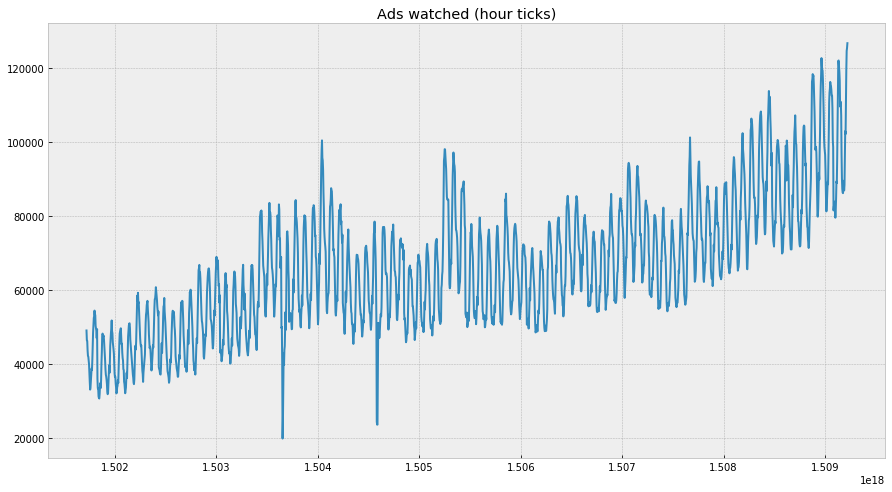

In [3]:
with plt.style.context('bmh'):    
    plt.figure(figsize=(15, 8))
    plt.title('Ads watched (hour ticks)')
    plt.plot(df.ads);

Тут есть и тренд, и различная сезонность, и немножко выбросов. 

В этом домашнем задании мы не будем пытаться подобрать наилучший ARIMA-процесс, порождающий наш ряд, и не затронем библиотеку Prophet от Facebook. Работа с этими методами очень подробна расписана во второй и третьей части ноутбуков по временным рядам в [репозитории](https://github.com/Yorko/mlcourse_open/tree/master/jupyter_notebooks/topic09_time_series) открытого курса по машинному обучению. 

А здесь мы сосредоточимся на построении и отборе признаков для временных рядов. 

Возьмем две полезные функции из [лекции](https://youtu.be/-iwjtvTxoVU) – для расчета среднего значения по таргету и для подготовки обучающего и тестового датасетов:

In [30]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(data, lag_start=5, lag_end=14, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data) * (1 - test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    
    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

Воспользуйтесь предложенными функциями и приготовьте из исходного датасета `df` необходимые для обучения датафреймы. Для тестирования отложите 30% данных, в качестве начального лага возьмите значения временного ряда 12 часов назад, а в качестве последнего лага - значения ряда 48 часов назад. Таким образом модель будет способна строить предсказания на 12 часов вперёд, имея фактические наблюдения за предыдущие полтора дня.

In [31]:
df.columns = ["y"]
df.head()

,y
Date,
2017-08-03 00:00:00,49136
2017-08-03 01:00:00,46450
2017-08-03 02:00:00,46355
2017-08-03 03:00:00,43748
2017-08-03 04:00:00,42281


In [32]:
# Ваш код здесь
X_train, X_test, y_train, y_test = prepareData(df, lag_start=12, lag_end=48, test_size=0.3)

Теперь обучите простую линейную регрессию на полученных данных:

In [33]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

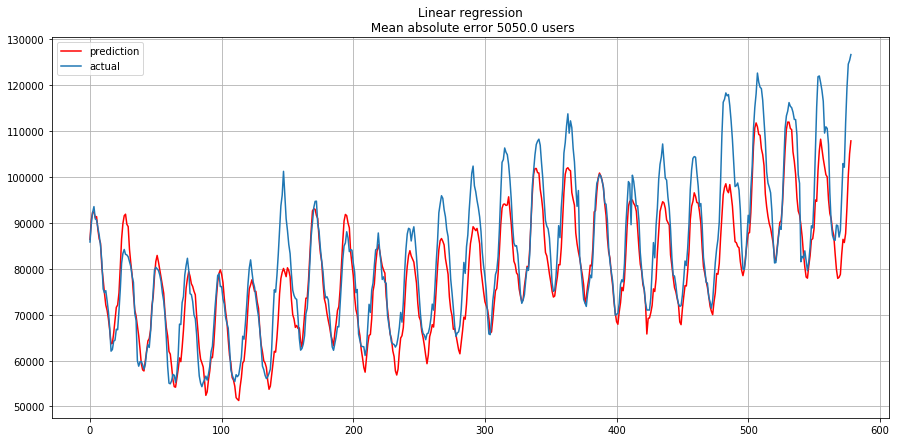

In [34]:
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

Оценим качество работы линейной регрессии на тренировочной части при помощи кросс-валидации. Для этого необходимо сначала создать объект-генератор разбиений для временного ряда при помощи `TimeSeriesSplit`. Число фолдов задайте равным 5. Затем воспользуйтесь методом `cross_val_score`, передав туда в качестве параметра `cv` созданный генератор разбиений. Метрикой качества будет выступать `neg_mean_absolute_error`. 

Не забудьте взять среднее от полученного значения и домножить его на -1. 

In [60]:
# Ваш код здесь
tscv = TimeSeriesSplit(n_splits=5)
cv_score = cross_val_score(lr, X_train, y_train, scoring="neg_mean_absolute_error", cv=tscv, n_jobs=-1)
print(-np.mean(cv_score))

4855.47412182


<font color='red'>Вопрос 1.</font> Чему равно среднее значение MAE на кросс-валидации?

- 3581
- 44903339
- 4855
- 0.68

Теперь посмотрим на результаты работы линейной регрессии на отложенной выборке. В этом нам поможет функция `plotModelResults`. В ней Вам нужно дописать часть, ответственную за расчет доверительных интервалов. Для расчета отклонения воспользуйтесь только что реализованным способом оценки качества на кросс-валидации – оттуда понадобится среднее значение MAE и стандартное отклонение этой величины.

In [67]:
def plotModelResults(model, X_train, X_test, plot_intervals=False):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        # Ваш код здесь
        # https://en.wikipedia.org/wiki/Prediction_interval#Known_mean.2C_known_variance
        cv_mean = -np.mean(cv_score)
        scale = 1.96
        lower = prediction - (cv_mean - scale * np.std(cv_score))
        upper = prediction + (cv_mean + scale * np.std(cv_score))
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
    plt.title("Mean absolute error {} ads".format(round(mean_absolute_error(prediction, y_test))))
    plt.legend(loc="best")
    plt.grid(True);

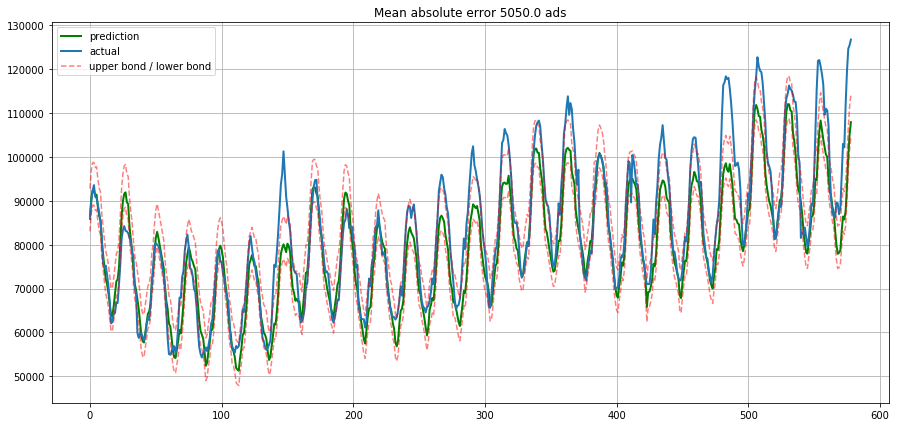

In [68]:
plotModelResults(lr, X_train, X_test, plot_intervals=True)

Замечательно, интервалы построены, прогнозы достаточно точные, и всё бы хорошо, если бы не одно но. В модели сейчас находятся 39 признаков и, возможно, какие-то из них лишние, и если их убрать, качество модели серьезно не пострадает. Чтобы убедиться, что у нас есть лишние признаки, постройте тепловую карту корреляций по `X_train`, поспользовавшись функцией `heatmap` из библиотеки `seaborn`:

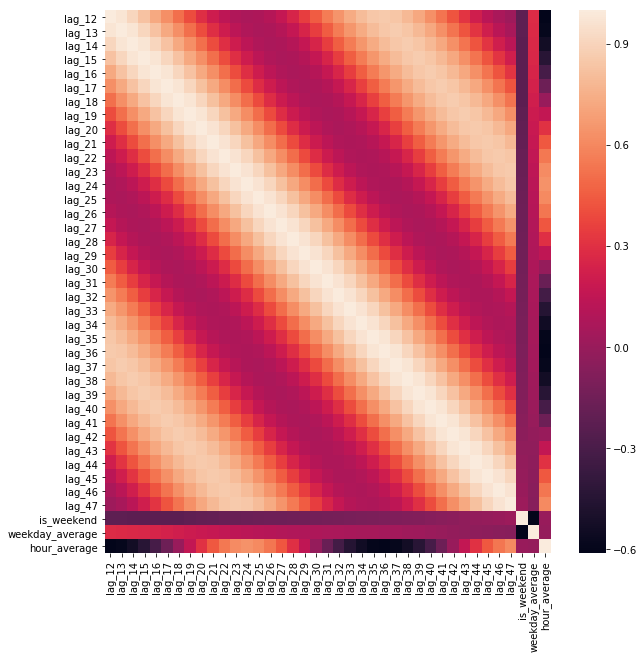

In [44]:
plt.figure(figsize=(10, 10))
sns.heatmap(X_train.corr(method='pearson'));

Действительно, налицо множество корреляций между нашими признаками, и даже видна "сезонность" в этих корреляциях на каждом 24-м лаге. Попробуем регуляризовать нашу модель и убрать несколько лишних переменных.

Для регуляризации нам понадобится сначала отмасштабировать признаки, для этого воспользуйстесь `StandardScaler` и создайте переменные `X_train_scaled` и `X_test_scaled`. Не забудьте, что обучать scaler нужно только на тренировочной выборке, чтобы информация о средних отклонениях не просочилась из будущего в прошлое. 

In [54]:
# Ваш код здесь
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучите на полученных отмасштабированных данных Лассо-регрессию на кросс-валидации (`LassoCV`), снова передав в качестве параметра `cv` созданный ранее генератор разбиений. 

Постройте график прогнозов с интервалами и убедитесь, что ошибка на тестовой выборке практически не изменилась.

In [73]:
# Ваш код здесь
lasso = LassoCV(n_jobs=-1, cv=tscv)
lasso.fit(X_train_scaled, y_train);

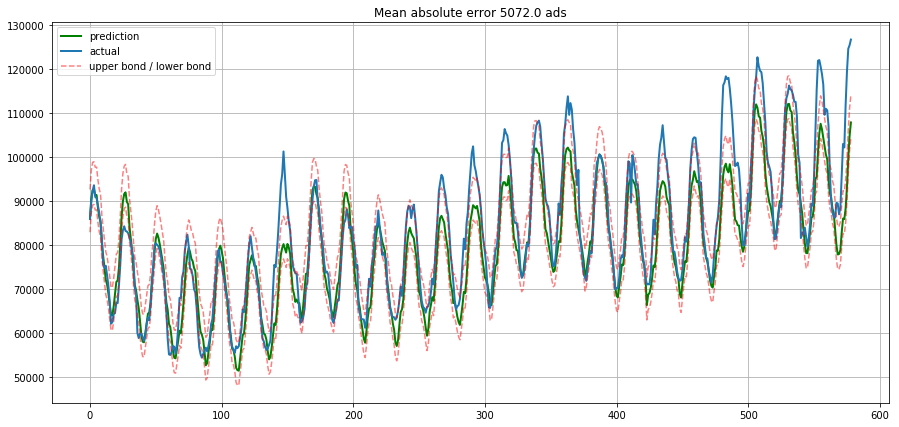

In [75]:
plotModelResults(lasso, X_train_scaled, X_test_scaled, plot_intervals=True)

Замечательно, качество нас всё ещё устраивает, интервалы по-прежднему адекватные, посмотрим, сильно ли мы упростили модель. Воспользуйтесь предложенной функцией `getCoefficients` и скажите, сколько признаков вошли в модель с зануленными весами.

In [77]:
def getCoefficients(model):
    """
    Возвращает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

In [80]:
print(getCoefficients(lasso))

                        coef
hour_average     6591.245254
lag_12           4595.789102
weekday_average  2211.550704
lag_24           1229.977688
lag_47           1153.519145
lag_36           -901.177954
lag_14           -796.479708
lag_25            771.477356
lag_18            745.536217
lag_23            683.571206
lag_26            624.443148
lag_46            609.039929
is_weekend        607.450295
lag_28            607.036811
lag_27            526.739514
lag_19            505.330517
lag_17            394.259093
lag_32            348.654697
lag_40           -332.653330
lag_21            309.187568
lag_44            307.220476
lag_13           -151.330442
lag_29            140.802394
lag_37           -140.415363
lag_31            137.026259
lag_30            133.026619
lag_33            132.858168
lag_41           -128.574393
lag_35           -126.705721
lag_22            107.666195
lag_16             15.296164
lag_38             -0.000000
lag_39             -0.000000
lag_34        

<font color='red'>Вопрос 2.</font> Сколько коэффициентов линейной модели равны нулю (с точностью до 6-го знака)?

- 1
- 3
- 5
- 8

Итак, признаковое пространство хоть немного, но удалось сократить. Что если пойти дальше и сжать наши линейно зависимые признаки в более компактное представление? Для этого воспользуемся методом главных компонент.

In [82]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

def plotPCA():
    """
    График накопленного процента объясненной дисперсии по компонентам
    """
    features = range(pca.n_components_)
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    plt.figure(figsize=(15, 7))
    plt.bar(features, variance)
    
    # дополнительно отметим уровень, при котором объяснены 90% дисперсии
    plt.hlines(y = 90, xmin=0, xmax=len(features), linestyles='dashed', colors='red')
    
    plt.xlabel('PCA components')
    plt.ylabel('variance')
    plt.xticks(features)
    plt.show()

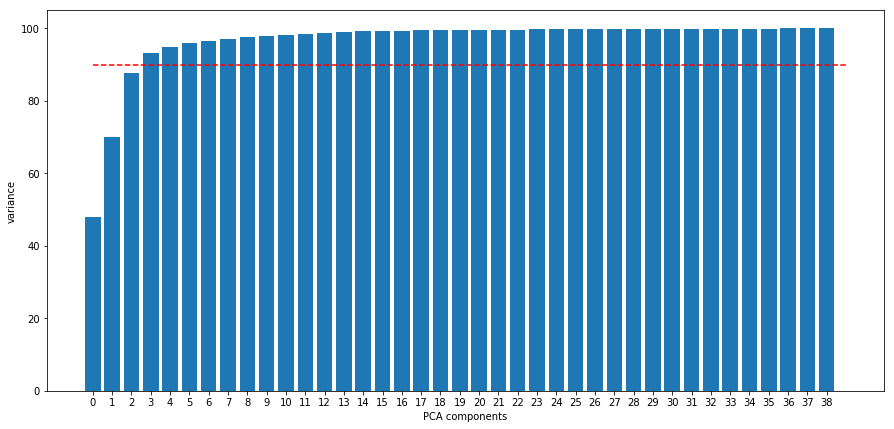

In [84]:
# Создайте объект PCA: pca
pca = PCA()

# Обучите pca на отмасштабированных данных
pca.fit(X_train_scaled, y_train)

# постройте график объясненной дисперсии
plotPCA()

<font color='red'>Вопрос 3.</font> Какое минимальное число компонент необходимо взять, чтобы объяснить минимум 90% всей дисперсии тренировочного датасета?

- 2
- 3
- 4
- 5

Снова создайте объект `pca`, указав при этом оптимальное число компонент (объясняющее минимум 90% изменчивости). Затем создайте две новых переменных – `pca_features_train` и `pca_features_test`, присвоив им, соответственно, преобразованные при помощи PCA отмасштабированные датафреймы. 

In [90]:
# Ваш код здесь
pca = PCA(n_components=4)
pca_features_train = pca.fit_transform(X_train_scaled)
pca_features_test = pca.transform(X_test_scaled)

На полученных данных снова обучите простую линейную регрессию и постройте график прогноза.

In [96]:
# Ваш код здесь
lr_new = LinearRegression()
lr_new.fit(pca_features_train, y_train)
prediction = lr_new.predict(pca_features_test)
print(round(mean_absolute_error(prediction, y_test)))

5730.0


<font color='red'>Вопрос 4.</font> Какая средняя абсолютная ошибка получилась у линейной регрессии, обученной на нескольких главных компонентах? 
- 5140
- 4917
- 6719
- 5730

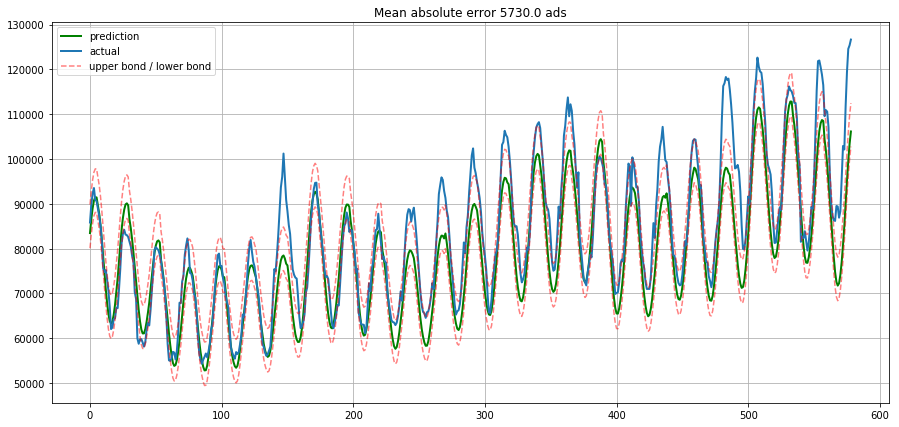

In [95]:
plotModelResults(lr_new, pca_features_test, pca_features_test, plot_intervals=True)